# Graphviz Layouts for Graphistry Visualization

The [graphviz engine](https://graphviz.org/) is popular for high-quality layout of small graphs, especially trees and directed acyclic graphs (DAGs).

This notebook shows how to use graphviz for **layout**, then visualize interactively with Graphistry's GPU-accelerated renderer.

**For static image export** (SVG, PNG for docs/reports), see the [static_rendering.ipynb](static_rendering.ipynb) notebook.

The example below shows laying out and rendering company ownership data that is in a tree and benefits from graphviz's high-quality layout engine.

## Setup

* graphviz: Install the graphviz engine and the pygraphviz bindings, see below (official [tutorial](https://pygraphviz.github.io/documentation/stable/install.html) )
* Graphistry: Install PyGraphistry below, and [get a free GPU account on Graphistry Hub](https://www.graphistry.com/get-started) or run your own server

Notes:

* You must install the graphviz engine, as well as its pygraphviz Python bindings and pygraphistry
* graphviz is most known for its `"dot"` layout engine, and it includes others as well
* graphviz is generally not recommended for layout of graphs over 10,000 nodes and edges

In [1]:
#!apt-get install graphviz graphviz-dev

#!pip install -q graphistry[pygraphviz]

## Imports

In [2]:
from typing import Any, Dict, Literal, Optional
import logging
try:
  import pygraphviz as pgv
except (ImportError, ModuleNotFoundError):
  logging.error("ImportError: Did you install pygraphviz and the supporting native packages?")
  raise

import pandas as pd
import graphistry
from graphistry import Plottable
graphistry.register(api=3, username=FILL_ME_IN, password=FILL_ME_IN)

graphistry.__version__

NameError: name 'FILL_ME_IN' is not defined

### Sample graph: HSBC Beneficial ownership graph

Sample data from [openownership.org](https://openownership.org/). Corporate ownership graphs often have deeply tree structure, and for bigger conglomerates with numerous subsidaries, officers, board officers, suppliers, and lenders, can greatly benefit from higher-quality tree layouts.

In [3]:
companies_df = pd.DataFrame([{'label': 'Hsbc Finance (Netherlands)', 'n': '1862294673469042014'},
 {'label': 'Hsbc Holdings Plc', 'n': '7622088245850069747'},
 {'label': 'Unknown person(s)', 'n': '7622088245850069747-unknown'},
 {'label': 'HSBC PROPERTY (UK) LIMITED', 'n': '16634236373777089526'},
 {'label': 'HSBC ALTERNATIVE INVESTMENTS LIMITED',
  'n': '18011320449780894329'},
 {'label': 'HSBC INVESTMENT COMPANY LIMITED', 'n': '9134577322728469115'},
 {'label': 'HSBC IM PENSION TRUST LIMITED', 'n': '1446072728533515665'},
 {'label': 'MERCANTILE COMPANY LIMITED', 'n': '6904185395252167658'},
 {'label': 'Mp Payments Group Limited', 'n': '13630126251685975826'},
 {'label': 'MP PAYMENTS OPERATIONS LIMITED', 'n': '11514603667851101425'},
 {'label': 'MP PAYMENTS UK LIMITED', 'n': '13417892994160273884'},
 {'label': 'Hsbc Asia Pacific Holdings (Uk) Limited',
  'n': '2173486047275631423'},
 {'label': 'HSBC SECURITIES (JAPAN) LIMITED', 'n': '18045747820524565803'}])

ownership_df = pd.DataFrame([{'s': '7622088245850069747', 'd': '1862294673469042014'},
 {'s': '7622088245850069747-unknown', 'd': '7622088245850069747'},
 {'s': '1862294673469042014', 'd': '16634236373777089526'},
 {'s': '1862294673469042014', 'd': '18011320449780894329'},
 {'s': '1862294673469042014', 'd': '9134577322728469115'},
 {'s': '9134577322728469115', 'd': '1446072728533515665'},
 {'s': '9134577322728469115', 'd': '6904185395252167658'},
 {'s': '9134577322728469115', 'd': '13630126251685975826'},
 {'s': '13630126251685975826', 'd': '11514603667851101425'},
 {'s': '13630126251685975826', 'd': '13417892994160273884'},
 {'s': '9134577322728469115', 'd': '2173486047275631423'},
 {'s': '2173486047275631423', 'd': '18045747820524565803'},
 {'s': '9134577322728469115', 'd': '16634236373777089526'}])

In [4]:
g = graphistry.edges(ownership_df, 's', 'd').nodes(companies_df, 'n').bind(point_title='label')

In [5]:
g = g.nodes(g._nodes.assign(sz=1)).encode_point_size('sz')

## Minimal tree layout and graphviz layout engines

Graphviz provides 15+ layout engines you can use. General guidance is to use for graphs up to 10,000 nodes and engines.

The `"dot"` layout engine is best known due to its beautiful hierarchical layouts for directed acycle graphs like trees.

In [6]:
g2 = g.layout_graphviz('dot')
g2.plot()

/app/graphistry/PlotterBase.py:2663: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  elist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')
/app/graphistry/PlotterBase.py:2678: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  nlist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')


ValueError: In api=1 mode, API key not set explicitly in `register()` or available at GRAPHISTRY_API_KEY

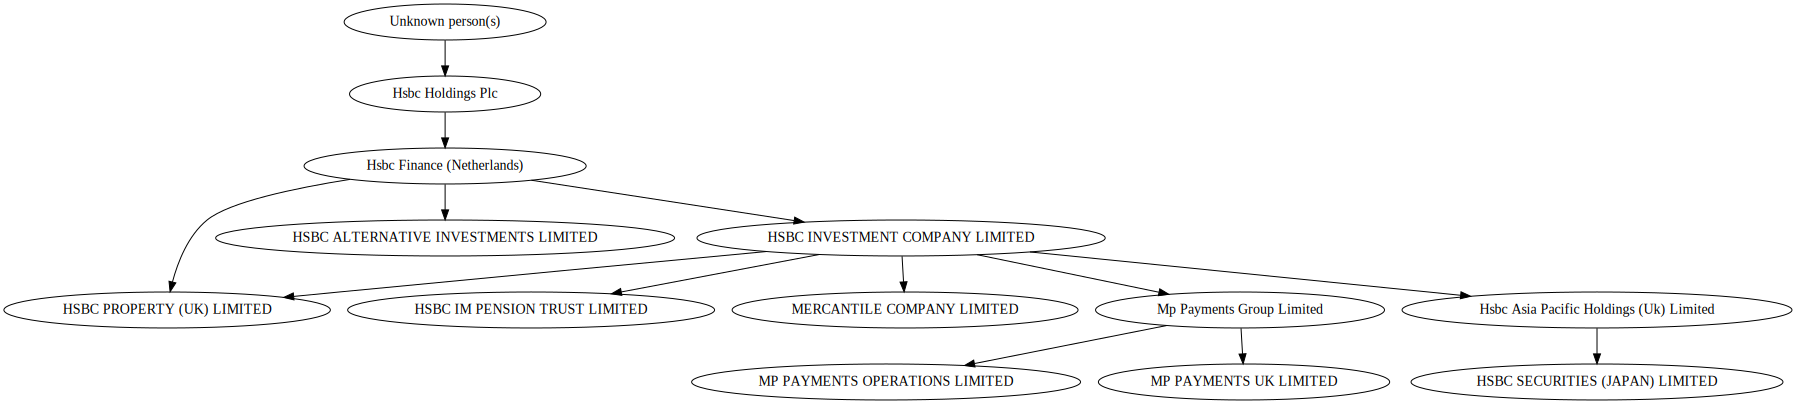

In [7]:
# Quick static render (see static_rendering.ipynb for full guide)
g.plot_static()

Additional layout engines beyond `"dot"` are below. See also the [graphviz layout engines documents](https://graphviz.org/docs/layouts/). The same documentation, and the below section on global graph attributes, describe options you can pass in to different layout engines.

In [8]:
from graphistry.plugins_types.graphviz_types import PROGS
PROGS

['acyclic',
 'ccomps',
 'circo',
 'dot',
 'fdp',
 'gc',
 'gvcolor',
 'gvpr',
 'neato',
 'nop',
 'osage',
 'patchwork',
 'sccmap',
 'sfdp',
 'tred',
 'twopi',
 'unflatten']

In [9]:
g2b = g.layout_graphviz('neato')
g2b.plot()

/app/graphistry/PlotterBase.py:2663: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  elist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')
/app/graphistry/PlotterBase.py:2678: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  nlist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')


ValueError: In api=1 mode, API key not set explicitly in `register()` or available at GRAPHISTRY_API_KEY

In [10]:
from graphistry.plugins_types.graphviz_types import PROGS

### Global attributes

You can set global attributes. Parameter [`graph_attr`](https://graphviz.org/docs/graph/) generally refers to layout engine options, while [`edge_attr`](https://graphviz.org/docs/edges/) and [`node_attr`](https://graphviz.org/docs/nodes/) are generally for default colors, sizes, shapes, etc.

In [11]:
g2b = g.layout_graphviz(
    'dot',
    graph_attr={'ratio': 10},
    edge_attr={},
    node_attr={}
)
g2b.plot()

/app/graphistry/PlotterBase.py:2663: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  elist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')
/app/graphistry/PlotterBase.py:2678: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  nlist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')


ValueError: In api=1 mode, API key not set explicitly in `register()` or available at GRAPHISTRY_API_KEY

In [12]:

from graphistry.plugins_types.graphviz_types import GRAPH_ATTRS
GRAPH_ATTRS

['_background',
 'bb',
 'beautify',
 'bgcolor',
 'center',
 'charset',
 'class',
 'clusterrank',
 'colorscheme',
 'comment',
 'compound',
 'concentrate',
 'Damping',
 'defaultdist',
 'dim',
 'dimen',
 'diredgeconstraints',
 'dpi',
 'epsilon',
 'esep',
 'fontcolor',
 'fontname',
 'fontnames',
 'fontpath',
 'fontsize',
 'forcelabels',
 'gradientangle',
 'href',
 'id',
 'imagepath',
 'inputscale',
 'K',
 'label',
 'label_scheme',
 'labeljust',
 'labelloc',
 'landscape',
 'layerlistsep',
 'layers',
 'layerselect',
 'layersep',
 'layout',
 'levels',
 'levelsgap',
 'lheight',
 'linelength',
 'lp',
 'lwidth',
 'margin',
 'maxiter',
 'mclimit',
 'mindist',
 'mode',
 'model',
 'newrank',
 'nodesep',
 'nojustify',
 'normalize',
 'notranslate',
 'nslimit',
 'nslimit1',
 'oneblock',
 'ordering',
 'orientation',
 'outputorder',
 'overlap',
 'overlap_scaling',
 'overlap_shrink',
 'pack',
 'packmode',
 'pad',
 'page',
 'pagedir',
 'quadtree',
 'quantum',
 'rankdir',
 'ranksep',
 'ratio',
 'remincross

In [13]:

from graphistry.plugins_types.graphviz_types import EDGE_ATTRS
EDGE_ATTRS

['arrowhead',
 'arrowsize',
 'arrowtail',
 'class',
 'color',
 'colorscheme',
 'comment',
 'constraint',
 'decorate',
 'dir',
 'edgehref',
 'edgetarget',
 'edgetooltip',
 'edgeURL',
 'fillcolor',
 'fontcolor',
 'fontname',
 'fontsize',
 'head_lp',
 'headclip',
 'headhref',
 'headlabel',
 'headport',
 'headtarget',
 'headtooltip',
 'headURL',
 'href',
 'id',
 'label',
 'labelangle',
 'labeldistance',
 'labelfloat',
 'labelfontcolor',
 'labelfontname',
 'labelfontsize',
 'labelhref',
 'labeltarget',
 'labeltooltip',
 'labelURL',
 'layer',
 'len',
 'lhead',
 'lp',
 'ltail',
 'minlen',
 'nojustify',
 'penwidth',
 'pos',
 'samehead',
 'sametail',
 'showboxes',
 'style',
 'tail_lp',
 'tailclip',
 'tailhref',
 'taillabel',
 'tailport',
 'tailtarget',
 'tailtooltip',
 'tailURL',
 'target',
 'tooltip',
 'URL',
 'weight',
 'xlabel',
 'xlp']

In [14]:

from graphistry.plugins_types.graphviz_types import NODE_ATTRS
NODE_ATTRS

['area',
 'class',
 'color',
 'colorscheme',
 'comment',
 'distortion',
 'fillcolor',
 'fixedsize',
 'fontcolor',
 'fontname',
 'fontsize',
 'gradientangle',
 'group',
 'height',
 'href',
 'id',
 'image',
 'imagepos',
 'imagescale',
 'label',
 'labelloc',
 'layer',
 'margin',
 'nojustify',
 'ordering',
 'orientation',
 'penwidth',
 'peripheries',
 'pin',
 'pos',
 'rects',
 'regular',
 'root',
 'samplepoints',
 'shape',
 'shapefile',
 'showboxes',
 'sides',
 'skew',
 'sortv',
 'style',
 'target',
 'tooltip',
 'URL',
 'vertices',
 'width',
 'xlabel',
 'xlp',
 'z']

## Per-entity styling attributes

You can add graphviz-specific columns to your node and edge dataframes that configure per-row render settings. These use the same names as in the above global attribute guidance, such as , , and .

Adding a column for an attribute will typically override the global attribute for that row.

In [15]:
g._nodes.apply(lambda row: row['n'], axis=1)

0             1862294673469042014
1             7622088245850069747
2     7622088245850069747-unknown
3            16634236373777089526
4            18011320449780894329
5             9134577322728469115
6             1446072728533515665
7             6904185395252167658
8            13630126251685975826
9            11514603667851101425
10           13417892994160273884
11            2173486047275631423
12           18045747820524565803
dtype: object

In [16]:
g._nodes.apply(lambda row: print('row', row['n']), 1)

row 1862294673469042014
row 7622088245850069747
row 7622088245850069747-unknown
row 16634236373777089526
row 18011320449780894329
row 9134577322728469115
row 1446072728533515665
row 6904185395252167658
row 13630126251685975826
row 11514603667851101425
row 13417892994160273884
row 2173486047275631423
row 18045747820524565803


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
dtype: object

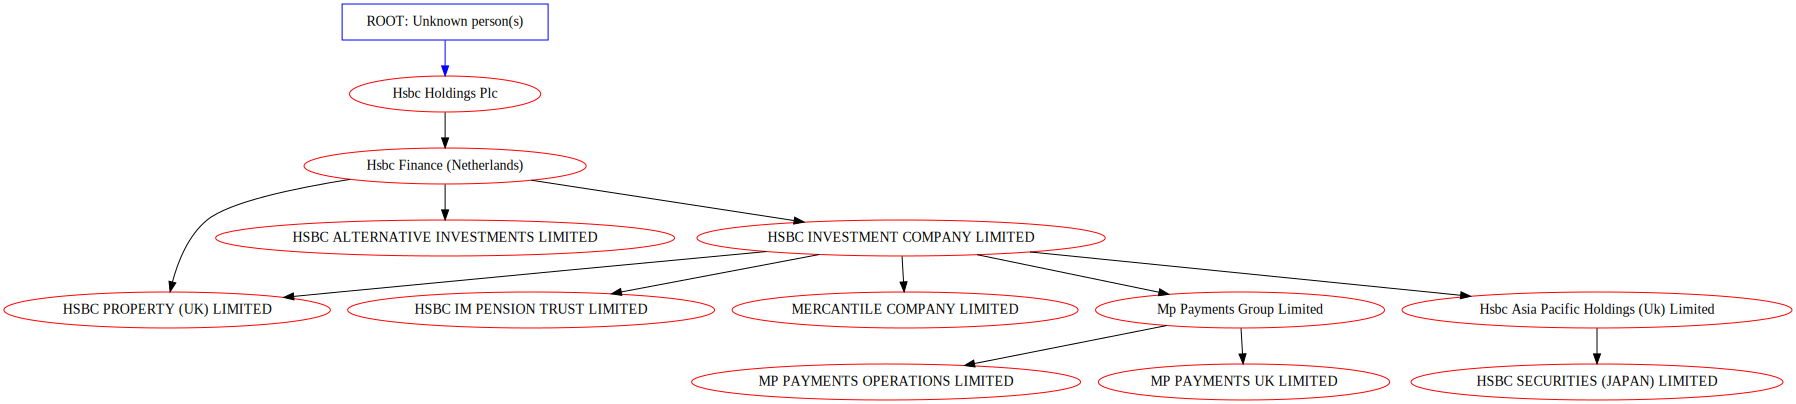

In [17]:
# Per-node styling with plot_static()

root_id = '7622088245850069747-unknown'

g2c = g.nodes(g._nodes.assign(
    label=g._nodes.apply(lambda row: "ROOT: Unknown person(s)" if row['n'] == root_id else row['label'], axis=1),
    shape=g._nodes.n.apply(lambda n: "box" if n == root_id else None),
    color=g._nodes.n.apply(lambda n: "blue" if n == root_id else 'red')
)).edges(g._edges.assign(
    color=g._edges[g._source].apply(lambda n: 'blue' if n == root_id else None)
))

# Static render with per-node styling
g2c.plot_static(
    prog='dot',
    node_attr={'color': 'green'}  # default, overridden by per-node color column
)

In [18]:
g2d = g.layout_graphviz('circo')
g2d.plot()

/app/graphistry/PlotterBase.py:2663: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  elist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')
/app/graphistry/PlotterBase.py:2678: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  nlist[obj_df.columns] = obj_df.apply(pd.to_numeric, errors='ignore')


ValueError: In api=1 mode, API key not set explicitly in `register()` or available at GRAPHISTRY_API_KEY

## See Also

- **[static_rendering.ipynb](static_rendering.ipynb)** - Static image export (SVG, PNG) for docs, reports, CI pipelines
- **[Graphviz documentation](https://graphviz.org/documentation/)** - Full attribute reference
- **[Layout catalog](../../../docs/source/visualization/layout/catalog.rst)** - All available layout algorithms